In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jcartus/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rc("figure", figsize=(8,4))

# Fetch Dataset 

In [52]:
from SCFInitialGuess.utilities.dataset import Data

target = "P"

data = Data()

#data.include(data_path = "../../dataset/MethanT/", postfix = "MethanT", target=target)

molecules = np.load("../butadien/data/400/molecules400.npy")
S = np.load("../butadien/data/400/S400.npy")
P = np.load("../butadien/data/400/P400.npy")

dim = 26
species = "C"

data._package_and_append(S, P, molecules, 0.8, 0.8)

#data.include(data_path = "../../dataset/QM9/", postfix = "QM9-300")

In [53]:
molecules = np.load("../butadien/data/molecules.npy")
S = np.load("../butadien/data/S.npy")
P = np.load("../butadien/data/P.npy")

dim = 26
species = "C"

data._package_and_append(S, P, molecules, 0.8, 0.8)

#data.include(data_path = "../../dataset/QM9/", postfix = "QM9-300")

In [80]:
path = "../thesis/dataset/TSmall_sto3g/"
molecules = np.load(path + "moleculesTSmall_sto3g.npy")
S = np.load(path + "STSmall_sto3g.npy")
P = np.load(path + "PTSmall_sto3g.npy")

dim = 26
species = "C"

data._package_and_append(S, P, molecules, 0.8, 0.8)

#data.include(data_path = "../../dataset/QM9/", postfix = "QM9-300")

In [81]:
#basis = "6-311++g**"
basis = "sto-3g"
#model_path="../../models/DescriptorC/" + target + "/"

# Descriptor 

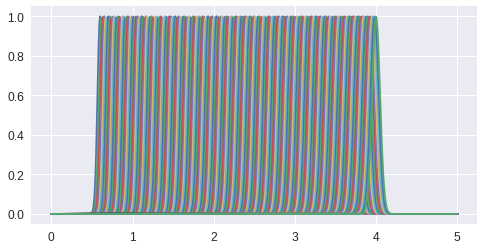

In [82]:
#from SCFInitialGuess.descriptors.models import make_uniform

def plot_normal_model(model, t):
    for r_s, eta in zip(model[0], model[1]):
        plt.plot(t, np.exp(-1 * eta*(t - r_s)**2))

def make_uniform(n, R_c=5, eta_max=30, eta_min=10):
    return (
        np.linspace(0.6,R_c*0.8, n),
        np.linspace(eta_max, eta_min, n),
    )
        
model = make_uniform(n=200, R_c=5, eta_min=200, eta_max=500)
#model = make_uniform(n=50, R_c=5, eta_min=100, eta_max=30)
plot_normal_model(model, np.linspace(0, 5, 500))

In [83]:
from SCFInitialGuess.utilities.dataset import make_center_block_dataset
from SCFInitialGuess.descriptors.high_level import AtomicNumberWeighted
from SCFInitialGuess.descriptors.cutoffs import BehlerCutoff1
from SCFInitialGuess.descriptors.models import RADIAL_GAUSSIAN_MODELS, make_uniform
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    Gaussians, SPHAngularDescriptor
import pickle

descriptor = AtomicNumberWeighted(
    #Gaussians(*RADIAL_GAUSSIAN_MODELS["Man"]),
    #Gaussians(*make_uniform(150, eta_max=200, eta_min=30)),
    Gaussians(*model),
    SPHAngularDescriptor(8),
    BehlerCutoff1(5)
)

#pickle.dump(descriptor, open(model_path + "descriptor.dump", "wb"))
    
descriptor.radial_descriptor.number_of_descriptors, descriptor.angular_descriptor.number_of_descriptors, descriptor.number_of_descriptors

(200, 162, 362)

In [84]:
from SCFInitialGuess.utilities.dataset import make_center_block_dataset
index=200
f = lambda x: x#(x[0][:index], x[0][index:(2*index)], x[2])

dataset_C = make_center_block_dataset(
    descriptor,
    data.molecules,
    data.T,
    "C"
)

#np.save(model_path + "normalisation.npy", (dataset_C.x_mean, dataset_C.x_std))


In [85]:
np.mean(dataset_C.testing[1][0])

0.31396368068528074

In [86]:
len(dataset_C.training[0]), len(dataset_C.validation[0]), len(dataset_C.testing[0]), 

(4612, 1156, 1448)

In [87]:
from SCFInitialGuess.utilities.dataset import AbstractDataset

x_train = AbstractDataset.denormalize(dataset_C.training[0], dataset_C.x_mean, dataset_C.x_std)
y_train = dataset_C.training[1]
np.mean(x_train[0] - x_train[-1])

0.012674128140906557

## Variance over time 

### Not normed 

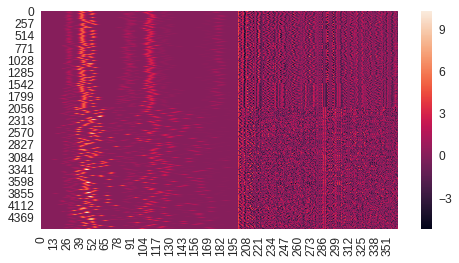

In [88]:
sns.heatmap(x_train)

### Normed 

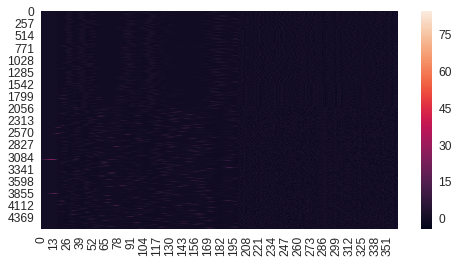

In [89]:
sns.heatmap(dataset_C.training[0])

### Output 

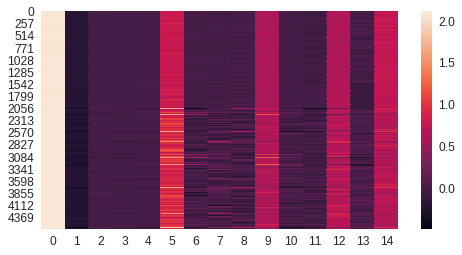

In [90]:
sns.heatmap(dataset_C.training[1])

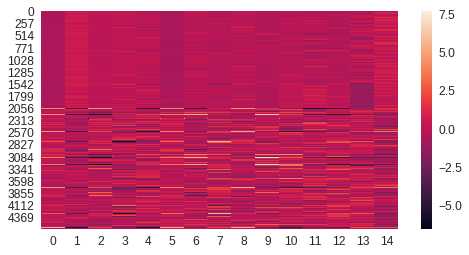

In [91]:
sns.heatmap(AbstractDataset.normalize(dataset_C.training[1])[0])

## Variance

In [92]:
np.var(x_train, 0).shape

(362,)

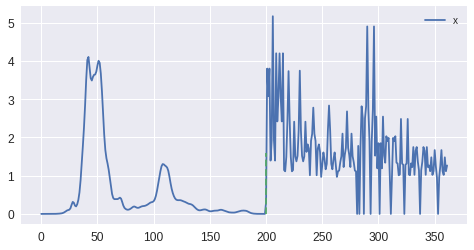

In [93]:
offset=0
plt.plot(np.var(x_train, 0)[offset:], label="x")
plt.plot([descriptor.radial_descriptor.number_of_descriptors - offset]*2, [1e-3, 1.6], "--")

plt.legend()

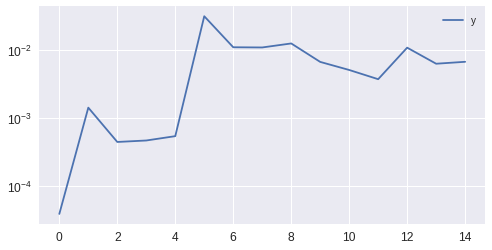

In [94]:
plt.semilogy(np.var(y_train, 0), label="y")
plt.legend()

# Average 

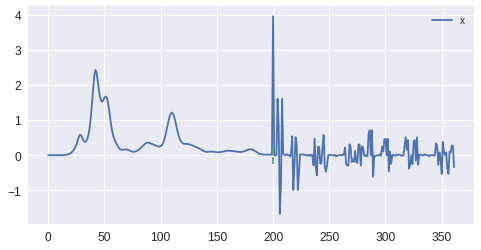

In [95]:
plt.plot(np.mean(x_train, 0), label="x")
plt.plot([descriptor.radial_descriptor.number_of_descriptors]*2, [-0.25, 0.25], "--")

plt.legend()

# Network Stuff 

In [96]:
#keras.backend.clear_session()

#activation = "elu"
#learning_rate = 1e-5

intializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)

def make_model(
        structure, 
        input_dim, 
        output_dim,
        activation="elu", 
        learning_rate=1e-3
    ):

    model = keras.Sequential()

    # input layer
    model.add(keras.layers.Dense(
        structure[0], 
        activation=activation, 
        input_dim=input_dim, 
        kernel_initializer=intializer
    ))

    for layer in structure[1:]:
        model.add(keras.layers.Dense(
            layer, 
            activation=activation, 
            #kernel_initializer=intializer, 
            #bias_initializer='zeros',
            kernel_regularizer=keras.regularizers.l2(1e-4)
        ))

    #output
    model.add(keras.layers.Dense(output_dim))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate), 
        loss='MSE', 
        metrics=['mse']
    )
    
    return model



In [97]:
#path = model_path

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mean_squared_error", 
    min_delta=1e-8, 
    patience=20, 
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', 
    factor=0.1, 
    patience=3, 
    verbose=1, 
    mode='auto', 
    min_delta=1e-6, 
    cooldown=2, 
    min_lr=1e-10
)


epochs = 1000


def train_model(model, dataset, filepath, learning_rate=1e-4, log_dir="./logs"):

    """
    tensorboard = keras.callbacks.TensorBoard(
        log_dir=log_dir, 
        histogram_freq=0, 
        batch_size=32, 
        #update_freq='epoch'
    )
    
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, 
        monitor='val_mean_squared_error', 
        verbose=1, 
        save_best_only=True, 
        save_weights_only=False, 
        mode='auto', 
        period=1
    )
    """
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    train, validation = [], []
    while True:
        keras.backend.set_value(model.optimizer.lr, learning_rate)
            
        history = model.fit(
            x = dataset.training[0],
            y = dataset.training[1],
            epochs=epochs,
            shuffle=True,
            validation_data=dataset.validation, 
            verbose=1, 
            callbacks=[
                early_stopping, 
                reduce_lr,
                #checkpoint,
                #tensorboard
            ]
        )
            
        
        #error.append(model.evaluate(
        #    dataset.testing[0], 
        #    dataset.testing[1], 
        #    verbose=1
        #)[1])
    
    return error
    

# Actucal training 

In [98]:
len(dataset_C.training[0]), len(dataset_C.validation[0]), len(dataset_C.testing[0]), 

(4612, 1156, 1448)

In [99]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS


species = "C"

dim_C = N_BASIS[basis][species]
dim_C_triu = dim_C * (dim_C + 1) // 2


In [100]:
descriptor.number_of_descriptors, dim_C_triu

(362, 15)

In [101]:
structure_C = [200, 100, 50]

In [102]:
keras.backend.clear_session()

In [103]:
model_C = make_model(
    structure=structure_C,
    input_dim=descriptor.number_of_descriptors,
    output_dim=dim_C_triu,
    
)

model_C.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               72600     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 15)                765       
Total params: 98,515
Trainable params: 98,515
Non-trainable params: 0
_________________________________________________________________


In [104]:
i =0
name_C = "C_" + target + ".h5"
name = "F/500-10"

In [ ]:
path=""
i+=1
train_model(
    model_C, 
    dataset_C, 
    path + name_C,
    learning_rate=1e-4,
    #log_dir="./logs/C/" + "all_" + str(i)
    log_dir="./logs/C/" + name + "_" + "x".join(list(map(str, structure_C))) + "_" + str(i)
)

Train on 4612 samples, validate on 1156 samples
Epoch 1/1000
4612/4612 [==============================] - 1s 174us/step - loss: 0.3253 - mean_squared_error: 0.3052 - val_loss: 0.0997 - val_mean_squared_error: 0.0796
Epoch 2/1000
4612/4612 [==============================] - 0s 107us/step - loss: 0.0470 - mean_squared_error: 0.0269 - val_loss: 0.0331 - val_mean_squared_error: 0.0130
Epoch 3/1000
4612/4612 [==============================] - 0s 106us/step - loss: 0.0307 - mean_squared_error: 0.0107 - val_loss: 0.0287 - val_mean_squared_error: 0.0087
Epoch 4/1000
4612/4612 [==============================] - 0s 106us/step - loss: 0.0276 - mean_squared_error: 0.0077 - val_loss: 0.0265 - val_mean_squared_error: 0.0067
Epoch 5/1000
4612/4612 [==============================] - 0s 105us/step - loss: 0.0258 - mean_squared_error: 0.0061 - val_loss: 0.0251 - val_mean_squared_error: 0.0054
Epoch 6/1000
4612/4612 [==============================] - 0s 104us/step - loss: 0.0246 - mean_squared_error: 0.0

4612/4612 [==============================] - 0s 106us/step - loss: 0.0099 - mean_squared_error: 6.8908e-04 - val_loss: 0.0101 - val_mean_squared_error: 8.9240e-04
Epoch 49/1000
4612/4612 [==============================] - 0s 103us/step - loss: 0.0099 - mean_squared_error: 6.8813e-04 - val_loss: 0.0100 - val_mean_squared_error: 8.8924e-04
Epoch 50/1000
4612/4612 [==============================] - 0s 108us/step - loss: 0.0098 - mean_squared_error: 6.8563e-04 - val_loss: 0.0100 - val_mean_squared_error: 8.8615e-04
Epoch 51/1000
4612/4612 [==============================] - 0s 106us/step - loss: 0.0098 - mean_squared_error: 6.8229e-04 - val_loss: 0.0100 - val_mean_squared_error: 8.8883e-04
Epoch 52/1000
4612/4612 [==============================] - 0s 104us/step - loss: 0.0097 - mean_squared_error: 6.7843e-04 - val_loss: 0.0099 - val_mean_squared_error: 8.8020e-04
Epoch 53/1000
4612/4612 [==============================] - 0s 103us/step - loss: 0.0097 - mean_squared_error: 6.7666e-04 - val_lo

4612/4612 [==============================] - 0s 106us/step - loss: 0.0077 - mean_squared_error: 5.6231e-04 - val_loss: 0.0079 - val_mean_squared_error: 7.4209e-04
Epoch 95/1000
4612/4612 [==============================] - 0s 103us/step - loss: 0.0077 - mean_squared_error: 5.5924e-04 - val_loss: 0.0078 - val_mean_squared_error: 7.3532e-04
Epoch 96/1000
4612/4612 [==============================] - 0s 104us/step - loss: 0.0076 - mean_squared_error: 5.5653e-04 - val_loss: 0.0078 - val_mean_squared_error: 7.3162e-04
Epoch 97/1000
4612/4612 [==============================] - 1s 109us/step - loss: 0.0076 - mean_squared_error: 5.5567e-04 - val_loss: 0.0077 - val_mean_squared_error: 7.3619e-04
Epoch 98/1000
4612/4612 [==============================] - 1s 110us/step - loss: 0.0075 - mean_squared_error: 5.5269e-04 - val_loss: 0.0077 - val_mean_squared_error: 7.3006e-04
Epoch 99/1000
4612/4612 [==============================] - 1s 110us/step - loss: 0.0075 - mean_squared_error: 5.5197e-04 - val_lo

4612/4612 [==============================] - 0s 107us/step - loss: 0.0059 - mean_squared_error: 4.5536e-04 - val_loss: 0.0060 - val_mean_squared_error: 6.2722e-04
Epoch 141/1000
4612/4612 [==============================] - 0s 104us/step - loss: 0.0059 - mean_squared_error: 4.5269e-04 - val_loss: 0.0060 - val_mean_squared_error: 6.2609e-04
Epoch 142/1000
4612/4612 [==============================] - 0s 102us/step - loss: 0.0059 - mean_squared_error: 4.5188e-04 - val_loss: 0.0060 - val_mean_squared_error: 6.2440e-04
Epoch 143/1000
4612/4612 [==============================] - 0s 100us/step - loss: 0.0059 - mean_squared_error: 4.5150e-04 - val_loss: 0.0060 - val_mean_squared_error: 6.2432e-04
Epoch 144/1000
4612/4612 [==============================] - 0s 106us/step - loss: 0.0059 - mean_squared_error: 4.5127e-04 - val_loss: 0.0060 - val_mean_squared_error: 6.2367e-04
Epoch 145/1000
4612/4612 [==============================] - 0s 102us/step - loss: 0.0059 - mean_squared_error: 4.5101e-04 - v

4612/4612 [==============================] - 0s 95us/step - loss: 0.0045 - mean_squared_error: 5.1667e-04 - val_loss: 0.0046 - val_mean_squared_error: 6.2251e-04
Epoch 9/1000
4612/4612 [==============================] - 0s 100us/step - loss: 0.0044 - mean_squared_error: 4.9784e-04 - val_loss: 0.0045 - val_mean_squared_error: 6.3412e-04
Epoch 10/1000
4612/4612 [==============================] - 0s 98us/step - loss: 0.0043 - mean_squared_error: 4.9854e-04 - val_loss: 0.0043 - val_mean_squared_error: 6.2022e-04
Epoch 11/1000
4612/4612 [==============================] - 1s 119us/step - loss: 0.0041 - mean_squared_error: 4.8856e-04 - val_loss: 0.0041 - val_mean_squared_error: 5.8230e-04
Epoch 12/1000
4612/4612 [==============================] - 1s 118us/step - loss: 0.0040 - mean_squared_error: 4.7309e-04 - val_loss: 0.0040 - val_mean_squared_error: 6.0139e-04
Epoch 13/1000
4612/4612 [==============================] - 1s 121us/step - loss: 0.0038 - mean_squared_error: 4.6018e-04 - val_loss:

4612/4612 [==============================] - 1s 124us/step - loss: 0.0034 - mean_squared_error: 3.3782e-04 - val_loss: 0.0036 - val_mean_squared_error: 4.8528e-04
Epoch 52/1000
4612/4612 [==============================] - 1s 117us/step - loss: 0.0034 - mean_squared_error: 3.3782e-04 - val_loss: 0.0036 - val_mean_squared_error: 4.8528e-04
Epoch 53/1000
4612/4612 [==============================] - 1s 115us/step - loss: 0.0034 - mean_squared_error: 3.3782e-04 - val_loss: 0.0036 - val_mean_squared_error: 4.8528e-04

Epoch 00053: ReduceLROnPlateau reducing learning rate to 1e-10.
Epoch 54/1000
4612/4612 [==============================] - 0s 108us/step - loss: 0.0034 - mean_squared_error: 3.3782e-04 - val_loss: 0.0036 - val_mean_squared_error: 4.8528e-04
Epoch 55/1000
4612/4612 [==============================] - 0s 103us/step - loss: 0.0034 - mean_squared_error: 3.3782e-04 - val_loss: 0.0036 - val_mean_squared_error: 4.8528e-04
Epoch 56/1000
4612/4612 [==============================] - 0s 10

4612/4612 [==============================] - 0s 105us/step - loss: 0.0025 - mean_squared_error: 2.8275e-04 - val_loss: 0.0026 - val_mean_squared_error: 4.1639e-04
Epoch 37/1000
4612/4612 [==============================] - 0s 101us/step - loss: 0.0025 - mean_squared_error: 2.8275e-04 - val_loss: 0.0026 - val_mean_squared_error: 4.1639e-04
Epoch 38/1000
4612/4612 [==============================] - 0s 102us/step - loss: 0.0025 - mean_squared_error: 2.8275e-04 - val_loss: 0.0026 - val_mean_squared_error: 4.1639e-04
Epoch 39/1000
4612/4612 [==============================] - 0s 105us/step - loss: 0.0025 - mean_squared_error: 2.8275e-04 - val_loss: 0.0026 - val_mean_squared_error: 4.1639e-04

Epoch 00039: ReduceLROnPlateau reducing learning rate to 1e-10.
Epoch 40/1000
4612/4612 [==============================] - 0s 105us/step - loss: 0.0025 - mean_squared_error: 2.8275e-04 - val_loss: 0.0026 - val_mean_squared_error: 4.1639e-04
Epoch 41/1000
4612/4612 [==============================] - 0s 10

4612/4612 [==============================] - 0s 102us/step - loss: 0.0010 - mean_squared_error: 1.8454e-04 - val_loss: 0.0012 - val_mean_squared_error: 2.9231e-04
Epoch 31/1000
4612/4612 [==============================] - 0s 104us/step - loss: 0.0010 - mean_squared_error: 1.8321e-04 - val_loss: 0.0011 - val_mean_squared_error: 2.9023e-04
Epoch 32/1000
4612/4612 [==============================] - 1s 114us/step - loss: 0.0010 - mean_squared_error: 1.8245e-04 - val_loss: 0.0011 - val_mean_squared_error: 2.8874e-04
Epoch 33/1000
4612/4612 [==============================] - 0s 102us/step - loss: 0.0010 - mean_squared_error: 1.8152e-04 - val_loss: 0.0011 - val_mean_squared_error: 2.8829e-04
Epoch 34/1000
4612/4612 [==============================] - 0s 103us/step - loss: 0.0010 - mean_squared_error: 1.8101e-04 - val_loss: 0.0011 - val_mean_squared_error: 2.8756e-04
Epoch 35/1000
4612/4612 [==============================] - 0s 103us/step - loss: 0.0010 - mean_squared_error: 1.8027e-04 - val_lo

Epoch 73/1000
4612/4612 [==============================] - 1s 136us/step - loss: 9.7432e-04 - mean_squared_error: 1.6781e-04 - val_loss: 0.0011 - val_mean_squared_error: 2.7760e-04

Epoch 00073: ReduceLROnPlateau reducing learning rate to 1e-10.
Epoch 00073: early stopping
Train on 4612 samples, validate on 1156 samples
Epoch 1/1000
4612/4612 [==============================] - 1s 131us/step - loss: 0.0011 - mean_squared_error: 2.8626e-04 - val_loss: 0.0011 - val_mean_squared_error: 3.8463e-04
Epoch 2/1000
4612/4612 [==============================] - 1s 129us/step - loss: 0.0011 - mean_squared_error: 3.5854e-04 - val_loss: 0.0012 - val_mean_squared_error: 4.9344e-04
Epoch 3/1000
4612/4612 [==============================] - 1s 132us/step - loss: 0.0010 - mean_squared_error: 3.2263e-04 - val_loss: 0.0011 - val_mean_squared_error: 3.9366e-04
Epoch 4/1000
4612/4612 [==============================] - 1s 137us/step - loss: 9.5964e-04 - mean_squared_error: 2.6186e-04 - val_loss: 0.0010 - val_m


Epoch 00041: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.
Epoch 42/1000
4612/4612 [==============================] - 1s 131us/step - loss: 5.3067e-04 - mean_squared_error: 1.1625e-04 - val_loss: 6.2735e-04 - val_mean_squared_error: 2.1293e-04
Epoch 43/1000
4612/4612 [==============================] - 1s 131us/step - loss: 5.3067e-04 - mean_squared_error: 1.1625e-04 - val_loss: 6.2735e-04 - val_mean_squared_error: 2.1293e-04
Epoch 44/1000
4612/4612 [==============================] - 1s 131us/step - loss: 5.3067e-04 - mean_squared_error: 1.1625e-04 - val_loss: 6.2735e-04 - val_mean_squared_error: 2.1293e-04
Epoch 45/1000
4612/4612 [==============================] - 1s 134us/step - loss: 5.3067e-04 - mean_squared_error: 1.1625e-04 - val_loss: 6.2735e-04 - val_mean_squared_error: 2.1293e-04

Epoch 00045: ReduceLROnPlateau reducing learning rate to 1e-10.
Epoch 46/1000
4612/4612 [==============================] - 1s 133us/step - loss: 5.3067e-04 - mean_squared_error: 

4612/4612 [==============================] - 1s 136us/step - loss: 3.8418e-04 - mean_squared_error: 9.3160e-05 - val_loss: 4.7424e-04 - val_mean_squared_error: 1.8322e-04
Epoch 27/1000
4612/4612 [==============================] - 1s 146us/step - loss: 3.8416e-04 - mean_squared_error: 9.3139e-05 - val_loss: 4.7421e-04 - val_mean_squared_error: 1.8320e-04
Epoch 28/1000
4612/4612 [==============================] - 1s 135us/step - loss: 3.8414e-04 - mean_squared_error: 9.3126e-05 - val_loss: 4.7419e-04 - val_mean_squared_error: 1.8318e-04
Epoch 29/1000
4612/4612 [==============================] - 1s 138us/step - loss: 3.8412e-04 - mean_squared_error: 9.3117e-05 - val_loss: 4.7417e-04 - val_mean_squared_error: 1.8317e-04

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
Epoch 30/1000
4612/4612 [==============================] - 1s 142us/step - loss: 3.8407e-04 - mean_squared_error: 9.3064e-05 - val_loss: 4.7417e-04 - val_mean_squared_error: 1.8317e-04
Epoch 3


Epoch 00018: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 19/1000
4612/4612 [==============================] - 0s 104us/step - loss: 2.9766e-04 - mean_squared_error: 8.3184e-05 - val_loss: 3.7436e-04 - val_mean_squared_error: 1.6005e-04
Epoch 20/1000
4612/4612 [==============================] - 0s 105us/step - loss: 2.9212e-04 - mean_squared_error: 7.7870e-05 - val_loss: 3.7213e-04 - val_mean_squared_error: 1.5801e-04
Epoch 21/1000
4612/4612 [==============================] - 0s 94us/step - loss: 2.9135e-04 - mean_squared_error: 7.7351e-05 - val_loss: 3.7214e-04 - val_mean_squared_error: 1.5821e-04
Epoch 22/1000
4612/4612 [==============================] - 0s 95us/step - loss: 2.9084e-04 - mean_squared_error: 7.7028e-05 - val_loss: 3.7067e-04 - val_mean_squared_error: 1.5694e-04
Epoch 23/1000
4612/4612 [==============================] - 0s 95us/step - loss: 2.9029e-04 - mean_squared_error: 7.6627e-05 - val_loss: 3.6985e-04 - val_mean_squared_error: 1.5639e-

4612/4612 [==============================] - 0s 95us/step - loss: 2.6060e-04 - mean_squared_error: 7.1792e-05 - val_loss: 3.3644e-04 - val_mean_squared_error: 1.4768e-04
Epoch 11/1000
4612/4612 [==============================] - 0s 93us/step - loss: 2.5940e-04 - mean_squared_error: 7.0653e-05 - val_loss: 3.3520e-04 - val_mean_squared_error: 1.4650e-04
Epoch 12/1000
4612/4612 [==============================] - 0s 95us/step - loss: 2.5882e-04 - mean_squared_error: 7.0218e-05 - val_loss: 3.3454e-04 - val_mean_squared_error: 1.4600e-04
Epoch 13/1000
4612/4612 [==============================] - 0s 95us/step - loss: 2.5816e-04 - mean_squared_error: 6.9717e-05 - val_loss: 3.3509e-04 - val_mean_squared_error: 1.4668e-04
Epoch 14/1000
4612/4612 [==============================] - 0s 96us/step - loss: 2.5764e-04 - mean_squared_error: 6.9321e-05 - val_loss: 3.3487e-04 - val_mean_squared_error: 1.4666e-04

Epoch 00014: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Epoch 15/1000

4612/4612 [==============================] - 0s 102us/step - loss: 2.5679e-04 - mean_squared_error: 8.8871e-05 - val_loss: 3.3363e-04 - val_mean_squared_error: 1.6660e-04
Epoch 11/1000
4612/4612 [==============================] - 0s 102us/step - loss: 2.5475e-04 - mean_squared_error: 8.8489e-05 - val_loss: 3.2266e-04 - val_mean_squared_error: 1.5715e-04
Epoch 12/1000
4612/4612 [==============================] - 0s 104us/step - loss: 2.5282e-04 - mean_squared_error: 8.8053e-05 - val_loss: 3.1708e-04 - val_mean_squared_error: 1.5304e-04
Epoch 13/1000
4612/4612 [==============================] - 0s 104us/step - loss: 2.4776e-04 - mean_squared_error: 8.4503e-05 - val_loss: 3.1555e-04 - val_mean_squared_error: 1.5294e-04
Epoch 14/1000
4612/4612 [==============================] - 1s 110us/step - loss: 2.4589e-04 - mean_squared_error: 8.4132e-05 - val_loss: 3.2233e-04 - val_mean_squared_error: 1.6103e-04
Epoch 15/1000
4612/4612 [==============================] - 0s 104us/step - loss: 2.4277e-

4612/4612 [==============================] - 0s 101us/step - loss: 2.5629e-04 - mean_squared_error: 9.8638e-05 - val_loss: 3.2437e-04 - val_mean_squared_error: 1.6808e-04
Epoch 2/1000
4612/4612 [==============================] - 0s 101us/step - loss: 2.6709e-04 - mean_squared_error: 1.1185e-04 - val_loss: 3.0971e-04 - val_mean_squared_error: 1.5481e-04
Epoch 3/1000
4612/4612 [==============================] - 0s 101us/step - loss: 2.4700e-04 - mean_squared_error: 9.3338e-05 - val_loss: 3.1204e-04 - val_mean_squared_error: 1.5900e-04
Epoch 4/1000
4612/4612 [==============================] - 0s 103us/step - loss: 2.4129e-04 - mean_squared_error: 8.8776e-05 - val_loss: 3.0731e-04 - val_mean_squared_error: 1.5616e-04
Epoch 5/1000
4612/4612 [==============================] - 0s 104us/step - loss: 2.3339e-04 - mean_squared_error: 8.2664e-05 - val_loss: 3.0079e-04 - val_mean_squared_error: 1.5046e-04
Epoch 6/1000
4612/4612 [==============================] - 0s 100us/step - loss: 2.2996e-04 - 

4612/4612 [==============================] - 0s 104us/step - loss: 1.8834e-04 - mean_squared_error: 4.8501e-05 - val_loss: 2.5874e-04 - val_mean_squared_error: 1.1890e-04
Epoch 43/1000
4612/4612 [==============================] - 0s 103us/step - loss: 1.8834e-04 - mean_squared_error: 4.8501e-05 - val_loss: 2.5874e-04 - val_mean_squared_error: 1.1890e-04

Epoch 00043: ReduceLROnPlateau reducing learning rate to 1e-10.
Epoch 44/1000
4612/4612 [==============================] - 0s 97us/step - loss: 1.8834e-04 - mean_squared_error: 4.8501e-05 - val_loss: 2.5874e-04 - val_mean_squared_error: 1.1890e-04
Epoch 45/1000
4612/4612 [==============================] - 0s 96us/step - loss: 1.8834e-04 - mean_squared_error: 4.8501e-05 - val_loss: 2.5874e-04 - val_mean_squared_error: 1.1890e-04
Epoch 46/1000
4612/4612 [==============================] - 0s 97us/step - loss: 1.8834e-04 - mean_squared_error: 4.8501e-05 - val_loss: 2.5874e-04 - val_mean_squared_error: 1.1890e-04
Epoch 00046: early stopping

4612/4612 [==============================] - 0s 100us/step - loss: 1.7155e-04 - mean_squared_error: 4.3587e-05 - val_loss: 2.3952e-04 - val_mean_squared_error: 1.1156e-04
Epoch 38/1000
4612/4612 [==============================] - 0s 96us/step - loss: 1.7155e-04 - mean_squared_error: 4.3587e-05 - val_loss: 2.3952e-04 - val_mean_squared_error: 1.1156e-04
Epoch 00038: early stopping
Train on 4612 samples, validate on 1156 samples
Epoch 1/1000
4612/4612 [==============================] - 0s 95us/step - loss: 2.0405e-04 - mean_squared_error: 7.6468e-05 - val_loss: 2.7630e-04 - val_mean_squared_error: 1.4993e-04
Epoch 2/1000
4612/4612 [==============================] - 0s 99us/step - loss: 2.1460e-04 - mean_squared_error: 8.8352e-05 - val_loss: 2.6375e-04 - val_mean_squared_error: 1.3817e-04
Epoch 3/1000
4612/4612 [==============================] - 0s 95us/step - loss: 2.0312e-04 - mean_squared_error: 7.8228e-05 - val_loss: 2.6032e-04 - val_mean_squared_error: 1.3586e-04
Epoch 4/1000
4612/46

4612/4612 [==============================] - 0s 95us/step - loss: 1.5561e-04 - mean_squared_error: 3.8830e-05 - val_loss: 2.2032e-04 - val_mean_squared_error: 1.0354e-04

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1e-10.
Epoch 41/1000
4612/4612 [==============================] - 0s 95us/step - loss: 1.5561e-04 - mean_squared_error: 3.8830e-05 - val_loss: 2.2032e-04 - val_mean_squared_error: 1.0354e-04
Epoch 42/1000
4612/4612 [==============================] - 0s 97us/step - loss: 1.5561e-04 - mean_squared_error: 3.8830e-05 - val_loss: 2.2032e-04 - val_mean_squared_error: 1.0354e-04
Epoch 43/1000
4612/4612 [==============================] - 0s 98us/step - loss: 1.5561e-04 - mean_squared_error: 3.8830e-05 - val_loss: 2.2032e-04 - val_mean_squared_error: 1.0354e-04
Epoch 44/1000
4612/4612 [==============================] - 0s 94us/step - loss: 1.5561e-04 - mean_squared_error: 3.8830e-05 - val_loss: 2.2032e-04 - val_mean_squared_error: 1.0354e-04

Epoch 00044: ReduceLROnPlate

4612/4612 [==============================] - 0s 97us/step - loss: 1.4369e-04 - mean_squared_error: 3.5452e-05 - val_loss: 2.0663e-04 - val_mean_squared_error: 9.8397e-05

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1e-10.
Epoch 35/1000
4612/4612 [==============================] - 0s 103us/step - loss: 1.4369e-04 - mean_squared_error: 3.5452e-05 - val_loss: 2.0663e-04 - val_mean_squared_error: 9.8397e-05
Epoch 36/1000
4612/4612 [==============================] - 1s 113us/step - loss: 1.4369e-04 - mean_squared_error: 3.5452e-05 - val_loss: 2.0663e-04 - val_mean_squared_error: 9.8397e-05
Epoch 37/1000
4612/4612 [==============================] - 1s 118us/step - loss: 1.4369e-04 - mean_squared_error: 3.5452e-05 - val_loss: 2.0663e-04 - val_mean_squared_error: 9.8397e-05
Epoch 38/1000
4612/4612 [==============================] - 1s 117us/step - loss: 1.4369e-04 - mean_squared_error: 3.5452e-05 - val_loss: 2.0663e-04 - val_mean_squared_error: 9.8397e-05

Epoch 00038: ReduceLROnP

4612/4612 [==============================] - 0s 98us/step - loss: 1.3400e-04 - mean_squared_error: 3.2712e-05 - val_loss: 1.9466e-04 - val_mean_squared_error: 9.3366e-05
Epoch 32/1000
4612/4612 [==============================] - 0s 100us/step - loss: 1.3400e-04 - mean_squared_error: 3.2712e-05 - val_loss: 1.9466e-04 - val_mean_squared_error: 9.3366e-05
Epoch 33/1000
4612/4612 [==============================] - 1s 113us/step - loss: 1.3400e-04 - mean_squared_error: 3.2712e-05 - val_loss: 1.9466e-04 - val_mean_squared_error: 9.3366e-05
Epoch 34/1000
4612/4612 [==============================] - 0s 101us/step - loss: 1.3400e-04 - mean_squared_error: 3.2712e-05 - val_loss: 1.9466e-04 - val_mean_squared_error: 9.3366e-05

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1e-10.
Epoch 35/1000
4612/4612 [==============================] - 0s 98us/step - loss: 1.3400e-04 - mean_squared_error: 3.2712e-05 - val_loss: 1.9466e-04 - val_mean_squared_error: 9.3366e-05
Epoch 36/1000
4612/4612 [=

Epoch 33/1000
4612/4612 [==============================] - 0s 99us/step - loss: 1.2719e-04 - mean_squared_error: 3.0780e-05 - val_loss: 1.8715e-04 - val_mean_squared_error: 9.0737e-05

Epoch 00033: ReduceLROnPlateau reducing learning rate to 1e-10.
Epoch 34/1000
4612/4612 [==============================] - 0s 99us/step - loss: 1.2719e-04 - mean_squared_error: 3.0780e-05 - val_loss: 1.8715e-04 - val_mean_squared_error: 9.0737e-05
Epoch 35/1000
4612/4612 [==============================] - 0s 97us/step - loss: 1.2719e-04 - mean_squared_error: 3.0780e-05 - val_loss: 1.8715e-04 - val_mean_squared_error: 9.0737e-05
Epoch 36/1000
4612/4612 [==============================] - 0s 97us/step - loss: 1.2719e-04 - mean_squared_error: 3.0780e-05 - val_loss: 1.8715e-04 - val_mean_squared_error: 9.0737e-05
Epoch 37/1000
4612/4612 [==============================] - 0s 98us/step - loss: 1.2719e-04 - mean_squared_error: 3.0780e-05 - val_loss: 1.8715e-04 - val_mean_squared_error: 9.0737e-05

Epoch 00037: R

4612/4612 [==============================] - 0s 95us/step - loss: 1.2336e-04 - mean_squared_error: 2.9669e-05 - val_loss: 1.8305e-04 - val_mean_squared_error: 8.9354e-05
Epoch 35/1000
4612/4612 [==============================] - 0s 97us/step - loss: 1.2336e-04 - mean_squared_error: 2.9669e-05 - val_loss: 1.8305e-04 - val_mean_squared_error: 8.9354e-05

Epoch 00035: ReduceLROnPlateau reducing learning rate to 1e-10.
Epoch 36/1000
4612/4612 [==============================] - 0s 97us/step - loss: 1.2336e-04 - mean_squared_error: 2.9669e-05 - val_loss: 1.8305e-04 - val_mean_squared_error: 8.9354e-05
Epoch 37/1000
4612/4612 [==============================] - 0s 95us/step - loss: 1.2336e-04 - mean_squared_error: 2.9669e-05 - val_loss: 1.8305e-04 - val_mean_squared_error: 8.9354e-05
Epoch 38/1000
4612/4612 [==============================] - 0s 97us/step - loss: 1.2336e-04 - mean_squared_error: 2.9669e-05 - val_loss: 1.8305e-04 - val_mean_squared_error: 8.9354e-05
Epoch 39/1000
4612/4612 [====

4612/4612 [==============================] - 0s 97us/step - loss: 1.1828e-04 - mean_squared_error: 2.8283e-05 - val_loss: 1.7679e-04 - val_mean_squared_error: 8.6801e-05
Epoch 36/1000
4612/4612 [==============================] - 0s 101us/step - loss: 1.1828e-04 - mean_squared_error: 2.8283e-05 - val_loss: 1.7679e-04 - val_mean_squared_error: 8.6801e-05

Epoch 00036: ReduceLROnPlateau reducing learning rate to 1e-10.
Epoch 00036: early stopping
Train on 4612 samples, validate on 1156 samples
Epoch 1/1000
4612/4612 [==============================] - 0s 102us/step - loss: 1.4369e-04 - mean_squared_error: 5.3339e-05 - val_loss: 2.0995e-04 - val_mean_squared_error: 1.1989e-04
Epoch 2/1000
4612/4612 [==============================] - 0s 101us/step - loss: 1.4615e-04 - mean_squared_error: 5.6634e-05 - val_loss: 1.9817e-04 - val_mean_squared_error: 1.0914e-04
Epoch 3/1000
4612/4612 [==============================] - 0s 100us/step - loss: 1.3660e-04 - mean_squared_error: 4.7911e-05 - val_loss: 

4612/4612 [==============================] - 0s 100us/step - loss: 1.1347e-04 - mean_squared_error: 2.6833e-05 - val_loss: 1.7117e-04 - val_mean_squared_error: 8.4536e-05
Epoch 40/1000
4612/4612 [==============================] - 0s 99us/step - loss: 1.1347e-04 - mean_squared_error: 2.6833e-05 - val_loss: 1.7117e-04 - val_mean_squared_error: 8.4536e-05

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1e-10.
Epoch 00040: early stopping
Train on 4612 samples, validate on 1156 samples
Epoch 1/1000
4612/4612 [==============================] - 0s 99us/step - loss: 1.3967e-04 - mean_squared_error: 5.2618e-05 - val_loss: 1.9548e-04 - val_mean_squared_error: 1.0889e-04
Epoch 2/1000
4612/4612 [==============================] - 0s 100us/step - loss: 1.4172e-04 - mean_squared_error: 5.5464e-05 - val_loss: 1.9044e-04 - val_mean_squared_error: 1.0495e-04
Epoch 3/1000
4612/4612 [==============================] - 0s 99us/step - loss: 1.3358e-04 - mean_squared_error: 4.8031e-05 - val_loss: 1.

4612/4612 [==============================] - 1s 114us/step - loss: 1.0965e-04 - mean_squared_error: 2.5757e-05 - val_loss: 1.6692e-04 - val_mean_squared_error: 8.3032e-05
Epoch 40/1000
4612/4612 [==============================] - 1s 115us/step - loss: 1.0965e-04 - mean_squared_error: 2.5757e-05 - val_loss: 1.6692e-04 - val_mean_squared_error: 8.3032e-05

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1e-10.
Epoch 41/1000
4612/4612 [==============================] - 1s 114us/step - loss: 1.0965e-04 - mean_squared_error: 2.5757e-05 - val_loss: 1.6692e-04 - val_mean_squared_error: 8.3032e-05
Epoch 00041: early stopping
Train on 4612 samples, validate on 1156 samples
Epoch 1/1000
4612/4612 [==============================] - 1s 117us/step - loss: 1.3216e-04 - mean_squared_error: 4.7924e-05 - val_loss: 1.9080e-04 - val_mean_squared_error: 1.0719e-04
Epoch 2/1000
4612/4612 [==============================] - 1s 120us/step - loss: 1.3944e-04 - mean_squared_error: 5.5990e-05 - val_loss

4612/4612 [==============================] - 0s 99us/step - loss: 1.2670e-04 - mean_squared_error: 4.6752e-05 - val_loss: 1.8065e-04 - val_mean_squared_error: 1.0064e-04
Epoch 4/1000
4612/4612 [==============================] - 0s 101us/step - loss: 1.2336e-04 - mean_squared_error: 4.3605e-05 - val_loss: 1.7602e-04 - val_mean_squared_error: 9.6404e-05
Epoch 5/1000
4612/4612 [==============================] - 0s 98us/step - loss: 1.1979e-04 - mean_squared_error: 4.0384e-05 - val_loss: 1.7469e-04 - val_mean_squared_error: 9.5438e-05
Epoch 6/1000
4612/4612 [==============================] - 0s 99us/step - loss: 1.1791e-04 - mean_squared_error: 3.8890e-05 - val_loss: 1.6944e-04 - val_mean_squared_error: 9.0603e-05
Epoch 7/1000
4612/4612 [==============================] - 0s 104us/step - loss: 1.1726e-04 - mean_squared_error: 3.8582e-05 - val_loss: 1.7214e-04 - val_mean_squared_error: 9.3588e-05
Epoch 8/1000
4612/4612 [==============================] - 0s 100us/step - loss: 1.1632e-04 - mea

4612/4612 [==============================] - 1s 134us/step - loss: 1.2268e-04 - mean_squared_error: 4.5140e-05 - val_loss: 1.8233e-04 - val_mean_squared_error: 1.0518e-04
Epoch 3/1000
4612/4612 [==============================] - 1s 134us/step - loss: 1.2065e-04 - mean_squared_error: 4.3603e-05 - val_loss: 1.7565e-04 - val_mean_squared_error: 9.8700e-05
Epoch 4/1000
4612/4612 [==============================] - 1s 165us/step - loss: 1.1683e-04 - mean_squared_error: 4.0107e-05 - val_loss: 1.7069e-04 - val_mean_squared_error: 9.4110e-05
Epoch 5/1000
4612/4612 [==============================] - 1s 129us/step - loss: 1.1494e-04 - mean_squared_error: 3.8547e-05 - val_loss: 1.6650e-04 - val_mean_squared_error: 9.0371e-05
Epoch 6/1000
4612/4612 [==============================] - 1s 129us/step - loss: 1.1418e-04 - mean_squared_error: 3.8004e-05 - val_loss: 1.6992e-04 - val_mean_squared_error: 9.3995e-05
Epoch 7/1000
4612/4612 [==============================] - 1s 142us/step - loss: 1.1280e-04 - 

4612/4612 [==============================] - 0s 107us/step - loss: 1.1508e-04 - mean_squared_error: 4.1051e-05 - val_loss: 1.6715e-04 - val_mean_squared_error: 9.3329e-05
Epoch 4/1000
4612/4612 [==============================] - 1s 113us/step - loss: 1.1037e-04 - mean_squared_error: 3.6736e-05 - val_loss: 1.7406e-04 - val_mean_squared_error: 1.0033e-04
Epoch 5/1000
4612/4612 [==============================] - 0s 102us/step - loss: 1.1108e-04 - mean_squared_error: 3.7521e-05 - val_loss: 1.5987e-04 - val_mean_squared_error: 8.6482e-05
Epoch 6/1000
4612/4612 [==============================] - 1s 115us/step - loss: 1.0845e-04 - mean_squared_error: 3.5216e-05 - val_loss: 1.6218e-04 - val_mean_squared_error: 8.9048e-05
Epoch 7/1000
4612/4612 [==============================] - 1s 126us/step - loss: 1.0904e-04 - mean_squared_error: 3.6127e-05 - val_loss: 1.6160e-04 - val_mean_squared_error: 8.8783e-05
Epoch 8/1000
4612/4612 [==============================] - 1s 138us/step - loss: 1.0671e-04 - 

4612/4612 [==============================] - 1s 137us/step - loss: 1.0547e-04 - mean_squared_error: 3.4447e-05 - val_loss: 1.5690e-04 - val_mean_squared_error: 8.5955e-05
Epoch 7/1000
4612/4612 [==============================] - 1s 135us/step - loss: 1.0408e-04 - mean_squared_error: 3.3266e-05 - val_loss: 1.5502e-04 - val_mean_squared_error: 8.4302e-05
Epoch 8/1000
4612/4612 [==============================] - 1s 138us/step - loss: 1.0336e-04 - mean_squared_error: 3.2792e-05 - val_loss: 1.5576e-04 - val_mean_squared_error: 8.5414e-05
Epoch 9/1000
4612/4612 [==============================] - 1s 136us/step - loss: 1.0272e-04 - mean_squared_error: 3.2414e-05 - val_loss: 1.5446e-04 - val_mean_squared_error: 8.4207e-05
Epoch 10/1000
4612/4612 [==============================] - 1s 138us/step - loss: 1.0236e-04 - mean_squared_error: 3.2314e-05 - val_loss: 1.5887e-04 - val_mean_squared_error: 8.8881e-05

Epoch 00010: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 11/10

Epoch 6/1000
4612/4612 [==============================] - 1s 144us/step - loss: 1.0196e-04 - mean_squared_error: 3.3430e-05 - val_loss: 1.5975e-04 - val_mean_squared_error: 9.1259e-05
Epoch 7/1000
4612/4612 [==============================] - 1s 139us/step - loss: 1.0426e-04 - mean_squared_error: 3.5818e-05 - val_loss: 1.5288e-04 - val_mean_squared_error: 8.4612e-05

Epoch 00007: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 8/1000
4612/4612 [==============================] - 1s 140us/step - loss: 9.1652e-05 - mean_squared_error: 2.3393e-05 - val_loss: 1.4313e-04 - val_mean_squared_error: 7.4882e-05
Epoch 9/1000
4612/4612 [==============================] - 1s 142us/step - loss: 8.9690e-05 - mean_squared_error: 2.1444e-05 - val_loss: 1.4264e-04 - val_mean_squared_error: 7.4390e-05
Epoch 10/1000
4612/4612 [==============================] - 1s 138us/step - loss: 8.9469e-05 - mean_squared_error: 2.1231e-05 - val_loss: 1.4241e-04 - val_mean_squared_error: 7.4179e-0

4612/4612 [==============================] - 1s 139us/step - loss: 8.7738e-05 - mean_squared_error: 2.1026e-05 - val_loss: 1.4048e-04 - val_mean_squared_error: 7.3749e-05
Epoch 9/1000
4612/4612 [==============================] - 1s 135us/step - loss: 8.7433e-05 - mean_squared_error: 2.0712e-05 - val_loss: 1.4045e-04 - val_mean_squared_error: 7.3723e-05
Epoch 10/1000
4612/4612 [==============================] - 1s 136us/step - loss: 8.7291e-05 - mean_squared_error: 2.0598e-05 - val_loss: 1.4003e-04 - val_mean_squared_error: 7.3324e-05

Epoch 00010: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Epoch 11/1000
4612/4612 [==============================] - 1s 139us/step - loss: 8.6600e-05 - mean_squared_error: 1.9904e-05 - val_loss: 1.3974e-04 - val_mean_squared_error: 7.3050e-05
Epoch 12/1000
4612/4612 [==============================] - 1s 138us/step - loss: 8.6498e-05 - mean_squared_error: 1.9805e-05 - val_loss: 1.3970e-04 - val_mean_squared_error: 7.3011e-05
Epoch 13/

Epoch 16/1000
4612/4612 [==============================] - 1s 133us/step - loss: 8.3506e-05 - mean_squared_error: 1.9016e-05 - val_loss: 1.3585e-04 - val_mean_squared_error: 7.1358e-05
Epoch 17/1000
4612/4612 [==============================] - 1s 118us/step - loss: 8.3476e-05 - mean_squared_error: 1.8988e-05 - val_loss: 1.3587e-04 - val_mean_squared_error: 7.1384e-05
Epoch 18/1000
4612/4612 [==============================] - 1s 124us/step - loss: 8.3459e-05 - mean_squared_error: 1.8974e-05 - val_loss: 1.3588e-04 - val_mean_squared_error: 7.1391e-05

Epoch 00018: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 19/1000
4612/4612 [==============================] - 1s 144us/step - loss: 8.3360e-05 - mean_squared_error: 1.8876e-05 - val_loss: 1.3587e-04 - val_mean_squared_error: 7.1384e-05
Epoch 20/1000
4612/4612 [==============================] - 1s 114us/step - loss: 8.3356e-05 - mean_squared_error: 1.8872e-05 - val_loss: 1.3586e-04 - val_mean_squared_error: 7.137

4612/4612 [==============================] - 1s 144us/step - loss: 8.1399e-05 - mean_squared_error: 1.8389e-05 - val_loss: 1.3396e-04 - val_mean_squared_error: 7.0946e-05
Epoch 21/1000
4612/4612 [==============================] - 1s 140us/step - loss: 8.1399e-05 - mean_squared_error: 1.8389e-05 - val_loss: 1.3396e-04 - val_mean_squared_error: 7.0946e-05
Epoch 22/1000
4612/4612 [==============================] - 1s 144us/step - loss: 8.1398e-05 - mean_squared_error: 1.8389e-05 - val_loss: 1.3395e-04 - val_mean_squared_error: 7.0945e-05
Epoch 23/1000
4612/4612 [==============================] - 1s 138us/step - loss: 8.1398e-05 - mean_squared_error: 1.8389e-05 - val_loss: 1.3395e-04 - val_mean_squared_error: 7.0944e-05

Epoch 00023: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.
Epoch 24/1000
4612/4612 [==============================] - 1s 131us/step - loss: 8.1397e-05 - mean_squared_error: 1.8388e-05 - val_loss: 1.3395e-04 - val_mean_squared_error: 7.0944e-05
Epoch 25


Epoch 00021: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
Epoch 22/1000
4612/4612 [==============================] - 0s 99us/step - loss: 7.9058e-05 - mean_squared_error: 1.7762e-05 - val_loss: 1.3095e-04 - val_mean_squared_error: 6.9657e-05
Epoch 23/1000
4612/4612 [==============================] - 0s 106us/step - loss: 7.9058e-05 - mean_squared_error: 1.7762e-05 - val_loss: 1.3095e-04 - val_mean_squared_error: 6.9657e-05
Epoch 24/1000
4612/4612 [==============================] - 0s 97us/step - loss: 7.9057e-05 - mean_squared_error: 1.7761e-05 - val_loss: 1.3095e-04 - val_mean_squared_error: 6.9657e-05
Epoch 25/1000
4612/4612 [==============================] - 0s 95us/step - loss: 7.9057e-05 - mean_squared_error: 1.7761e-05 - val_loss: 1.3095e-04 - val_mean_squared_error: 6.9656e-05

Epoch 00025: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.
Epoch 26/1000
4612/4612 [==============================] - 0s 93us/step - loss: 7.9056e-05 - mean_sq

Epoch 28/1000
4612/4612 [==============================] - 0s 100us/step - loss: 7.7553e-05 - mean_squared_error: 1.7380e-05 - val_loss: 1.2944e-04 - val_mean_squared_error: 6.9262e-05
Epoch 29/1000
4612/4612 [==============================] - 0s 96us/step - loss: 7.7553e-05 - mean_squared_error: 1.7380e-05 - val_loss: 1.2944e-04 - val_mean_squared_error: 6.9262e-05
Epoch 30/1000
4612/4612 [==============================] - 0s 96us/step - loss: 7.7553e-05 - mean_squared_error: 1.7380e-05 - val_loss: 1.2944e-04 - val_mean_squared_error: 6.9262e-05

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1e-10.
Epoch 31/1000
4612/4612 [==============================] - 0s 98us/step - loss: 7.7553e-05 - mean_squared_error: 1.7380e-05 - val_loss: 1.2944e-04 - val_mean_squared_error: 6.9262e-05
Epoch 32/1000
4612/4612 [==============================] - 0s 95us/step - loss: 7.7553e-05 - mean_squared_error: 1.7380e-05 - val_loss: 1.2944e-04 - val_mean_squared_error: 6.9262e-05
Epoch 33/1000


4612/4612 [==============================] - 1s 136us/step - loss: 7.6142e-05 - mean_squared_error: 1.7073e-05 - val_loss: 1.2797e-04 - val_mean_squared_error: 6.8896e-05

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1e-10.
Epoch 35/1000
4612/4612 [==============================] - 1s 136us/step - loss: 7.6142e-05 - mean_squared_error: 1.7073e-05 - val_loss: 1.2797e-04 - val_mean_squared_error: 6.8896e-05
Epoch 36/1000
4612/4612 [==============================] - 1s 138us/step - loss: 7.6142e-05 - mean_squared_error: 1.7073e-05 - val_loss: 1.2797e-04 - val_mean_squared_error: 6.8896e-05
Epoch 00036: early stopping
Train on 4612 samples, validate on 1156 samples
Epoch 1/1000
4612/4612 [==============================] - 1s 134us/step - loss: 9.8009e-05 - mean_squared_error: 3.8180e-05 - val_loss: 1.4880e-04 - val_mean_squared_error: 8.9533e-05
Epoch 2/1000
4612/4612 [==============================] - 1s 137us/step - loss: 9.3507e-05 - mean_squared_error: 3.4404e-05 - val_loss

4612/4612 [==============================] - 1s 139us/step - loss: 8.6720e-05 - mean_squared_error: 2.9649e-05 - val_loss: 1.3504e-04 - val_mean_squared_error: 7.8004e-05
Epoch 5/1000
4612/4612 [==============================] - 1s 137us/step - loss: 8.4703e-05 - mean_squared_error: 2.7738e-05 - val_loss: 1.3387e-04 - val_mean_squared_error: 7.7100e-05
Epoch 6/1000
3456/4612 [=====================>........] - ETA: 0s - loss: 8.3702e-05 - mean_squared_error: 2.6948e-05

In [ ]:
error